<a href="https://colab.research.google.com/github/TheoLequy/HappinessHackers/blob/main/DataAnalysis_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [31]:
# XGBoost is typically the best for a lot of this kind of stuff (https://dataaspirant.com/xgboost-algorithm/)
# google xgboost kaggle and youll see what i mean
!pip install xgboost

import pandas as pd
import numpy as np
from xgboost import XGBRegressor

# Rest of everything we use will probably be sklearn cause its the easiest to use
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# Clone the github repo with all the data
!git clone https://github.com/TheoLequy/HappinessHackers.git

# Change to this directory
%cd HappinessHackers

# List the files
!ls

Cloning into 'HappinessHackers'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 185 (delta 3), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (185/185), 7.61 MiB | 13.79 MiB/s, done.
Resolving deltas: 100% (93/93), done.
/content/HappinessHackers
data		       DataProcessing.ipynb	 final_dataset_raw.csv	  Plotting.ipynb
DataAnalysis_ML.ipynb  final_dataset_filled.csv  final_filled_region.csv  README.md


# Load Dataset, Fill missing Values

In [4]:
df = pd.read_csv('final_dataset_filled.csv')

# Sets x data to be everything except happiness rank and score
# (country and region are removed because they are non-numeric but could be added in with some proprocessing)
X_with_labels = df.drop(["code", "year", "happiness"], axis=1)
y = df["happiness"]

country_labels = df["code"] + ', ' + df["year"].astype(str)

# This cell imputes the data and then scales the data to be normally distributed with mean 0 and standard variance
# helps a lot with linear regression but probs wont make too much of a difference in ensemble methods
# Create a pipeline with imputation and scaling
data_preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values using the mean
    ('scaler', StandardScaler())  # Scale data
])

X = data_preprocessing.fit_transform(X_with_labels)
codes = np.array(df["code"].drop_duplicates())

# Linregress + Covariance

In [54]:
s = 20
kf = KFold(n_splits=s, shuffle=True)
mse_in_sample = []
mse_out_sample = []
coefs = pd.DataFrame(columns = X_with_labels.columns)
print(coefs)
X_const = sm.add_constant(X)
i=0
for train_country_index, val_country_index in kf.split(codes):
  # Split the dataset into training and validation sets based on countries
  train_index = df["code"].isin(codes[train_country_index])
  val_index = df["code"].isin(codes[val_country_index])
  X_train, X_val = X_const[train_index], X_const[val_index]
  y_train, y_val = y[train_index], y[val_index]

  model = sm.OLS(y_train, X_train)
  res = model.fit()
  mse_in_sample.append(mean_squared_error(res.predict(X_train), y_train))
  mse_out_sample.append(mean_squared_error(res.predict(X_val), y_val))
  coefs.append(pd.DataFrame(res.params))
  i+=1
in_sample_error = np.mean(mse_in_sample)
out_sample_error = np.mean(mse_out_sample)
avg_coefs = np.mean(coefs, axis=1)
std_coefs = np.std(coefs, axis=1)

print(in_sample_error)
print(out_sample_error)

Empty DataFrame
Columns: [gdppc, urbanization, corruption, food_insec, tax, indiv_libs, school, life_expect, yearly temp, hri, suicides, family, covid, war, hdi, rain, air_pollution, gini]
Index: []


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [36]:
# Fit the OLS regression model
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

# Get coefficients and standard errors
coefficients = results.params
std_errors = results.bse

# Extract feature names from the list
feature_names = df.columns[3:]

# Create a bar plot with error bars using Plotly
fig = go.Figure()

fig.add_trace(go.Bar(
    x=feature_names,
    y=coefficients[1:],
    error_y=dict(type='data', array=std_errors, visible=True),
    marker_color='rgb(26, 118, 255)',
))

fig.update_layout(
    title='Coefficients of OLS Regression with Error Bars',
    xaxis=dict(title='Features', tickangle=45),
    yaxis=dict(title='Coefficients'),
    showlegend=False,
)

fig.show()

# PCA

In [47]:
pcs = [1,2]

pca = PCA(n_components=np.max(pcs))
X_pca = pca.fit_transform(X)

px_data = pd.DataFrame({f'PC {pcs[0]}': X_pca[:, pcs[0]-1], f'PC {pcs[1]}': X_pca[:, pcs[1]-1],
                        'Country': country_labels, 'Happiness': y})

# Create an interactive scatter plot using Plotly
fig = px.scatter(px_data, x=f'PC {pcs[0]}', y=f'PC {pcs[1]}', color='Happiness', hover_data=['Country'])

# Update layout to add axis labels and title
fig.update_layout(title='Interactive Scatter Plot over 2 Principal Components',
                  xaxis_title=f'Principal Component {pcs[0]}',
                  yaxis_title=f'Principal Component {pcs[1]}')


# PCA + Linregress

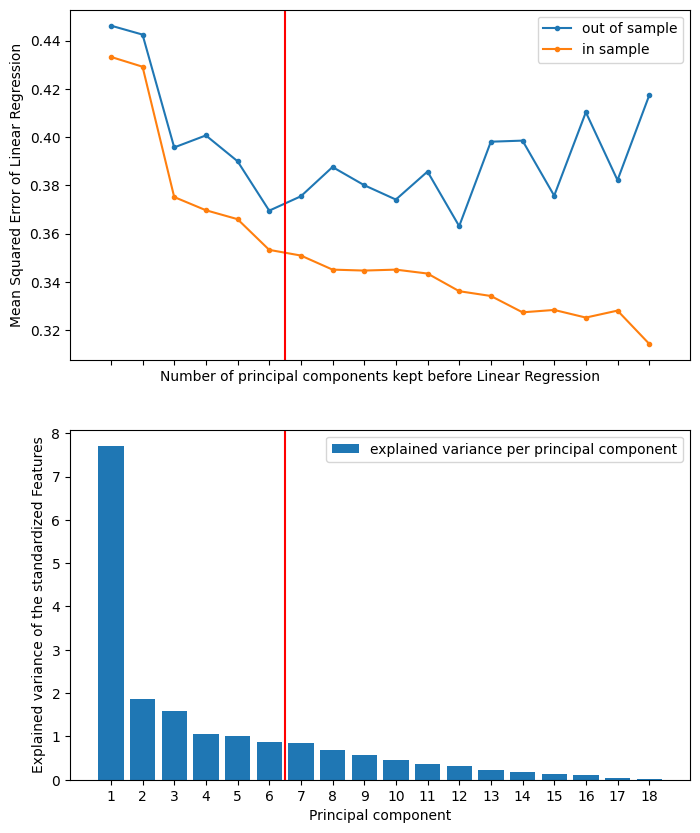

In [35]:
# determining best number of pca components

kf = KFold(n_splits=5, shuffle=True)
n_feat = len(X_with_labels.columns)
n_comps = range(1,n_feat+1)
principal_variance = np.zeros(len(n_comps))
errors = np.ones((len(n_comps), 2))
lin_reg_coefs = np.zeros(n_feat)

for n in n_comps:
  pca = PCA(n_components=n)
  X_pca = pca.fit_transform(X)
  if n == n_feat:
    principal_variance = pca.explained_variance_

  model = LinearRegression() #, XGBRegressor(objective='reg:squarederror', n_estimators=100)]
  mse_in_sample = []
  mse_out_sample = []
  for train_country_index, val_country_index in kf.split(codes):

    # Split the dataset into training and validation sets based on countries
    train_index = df["code"].isin(codes[train_country_index])
    val_index = df["code"].isin(codes[val_country_index])
    X_train, X_val = X_pca[train_index], X_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model.fit(X_train, y_train)

    mse_in_sample.append(mean_squared_error(model.predict(X_train), y_train))
    mse_out_sample.append(mean_squared_error(model.predict(X_val), y_val))
  errors[n-1, 0] = np.mean(mse_in_sample)
  errors[n-1, 1] = np.mean(mse_out_sample)



fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8,10))
ax1.plot(n_comps, errors[:,1], '.-', label='out of sample')
ax1.plot(n_comps, errors[:,0], '.-', label='in sample')
ax2.bar(n_comps, principal_variance, label='explained variance per principal component')
ax1.set_xlabel("Number of principal components kept before Linear Regression")
ax1.set_ylabel("Mean Squared Error of Linear Regression")
ax1.axvline(6.5, c='r')
ax2.axvline(6.5, c='r')
ax2.set_ylabel("Explained variance of the standardized Features")
ax2.set_xlabel("Principal component")
ax2.set_xticks(n_comps)
ax1.legend()
ax2.legend()

Text(0, 0.5, 'coefficient for linear regression with n principal components')

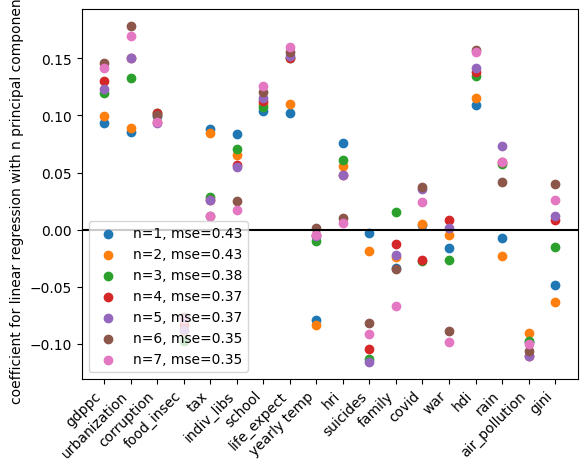

In [6]:
fig, ax = plt.subplots()
ax.axhline(0,c='k')
for n in range(1,8):
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)

    principal_variance = pca.explained_variance_

    model = LinearRegression() #, XGBRegressor(objective='reg:squarederror', n_estimators=100)]

    model.fit(X_pca, y)

    mse = mean_squared_error(model.predict(X_pca), y)
    expl_var = explained_variance_score(model.predict(X_pca), y)

    lin_reg_coefs = pca.inverse_transform(model.coef_)

    feature_labels = X_with_labels.columns.values
    ax.scatter(feature_labels, lin_reg_coefs, label=f"n={n}, mse={mse:.2f}")


plt.xticks(rotation=45, ha='right')
plt.legend()
ax.set_ylabel("coefficient for linear regression with n principal components")

# PCA + Polynomial Regression

In [72]:
# determining best number of pca components and degree
deg = 3
kf = KFold(n_splits=5, shuffle=True)
n = 1

pca = PCA(n_components=n)
X_pca = pca.fit_transform(X)

poly = PolynomialFeatures(degree=deg)
X_poly = poly.fit_transform(X)

if n == n_feat:
  principal_variance = pca.explained_variance_

model = Ridge(alpha=1e5)
mse_in_sample = []
mse_out_sample = []
for train_country_index, val_country_index in kf.split(codes):

  # Split the dataset into training and validation sets based on countries
  train_index = df["code"].isin(codes[train_country_index])
  val_index = df["code"].isin(codes[val_country_index])
  X_train, X_val = X_poly[train_index], X_poly[val_index]
  y_train, y_val = y[train_index], y[val_index]

  model.fit(X_train, y_train)

  mse_in_sample.append(mean_squared_error(model.predict(X_train), y_train))
  mse_out_sample.append(mean_squared_error(model.predict(X_val), y_val))



print(np.mean(mse_in_sample))
print(np.mean(mse_out_sample))

0.39820777453507306
0.5359550198493184


# Lasso Regularization

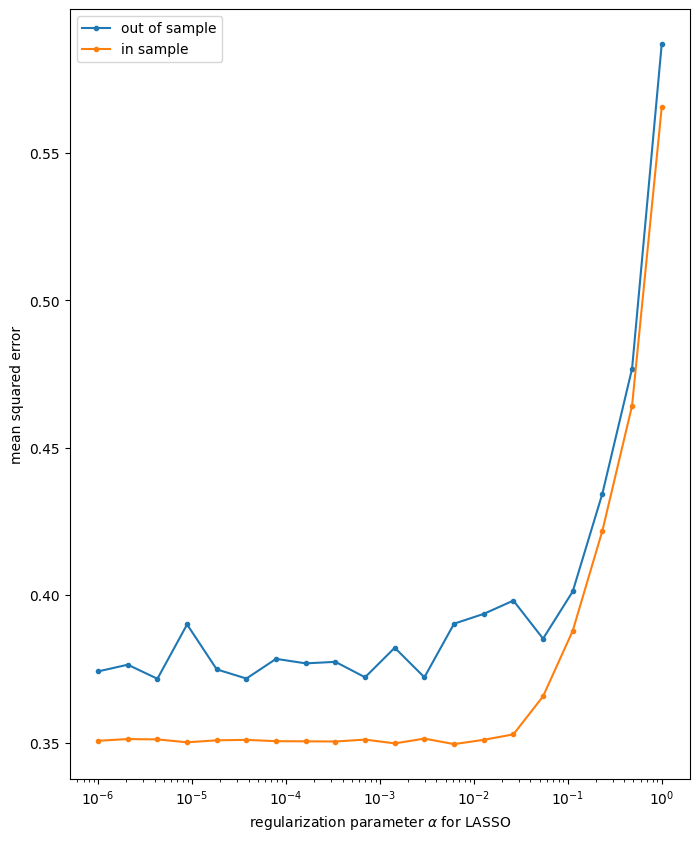

In [7]:
# determining best lasso regularization parameter

kf = KFold(n_splits=5, shuffle=True)
n_feat = len(X_with_labels.columns)
alphas = np.logspace(-6, 0,20)

errors = np.ones((len(alphas), 2))
lin_reg_coefs = np.zeros(n_feat)
for i, a in enumerate(alphas):
  model = Lasso(alpha=a)
  mse_in_sample = []
  mse_out_sample = []
  for train_country_index, val_country_index in kf.split(codes):

    # Split the dataset into training and validation sets based on countries
    train_index = df["code"].isin(codes[train_country_index])
    val_index = df["code"].isin(codes[val_country_index])
    X_train, X_val = X_pca[train_index], X_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model.fit(X_train, y_train)

    mse_in_sample.append(mean_squared_error(model.predict(X_train), y_train))
    mse_out_sample.append(mean_squared_error(model.predict(X_val), y_val))
  errors[i, 0] = np.mean(mse_in_sample)
  errors[i, 1] = np.mean(mse_out_sample)



fig, ax = plt.subplots(figsize=(8,10))
ax.plot(alphas, errors[:,1], '.-', label='out of sample')
ax.plot(alphas, errors[:,0], '.-', label='in sample')
ax.set_xlabel(r"regularization parameter $\alpha$ for LASSO")
ax.set_ylabel("mean squared error")
ax.set_xscale("log")
ax.legend()


Text(0, 0.5, 'coefficient for LASSO with $\\alpha = 0.1$')

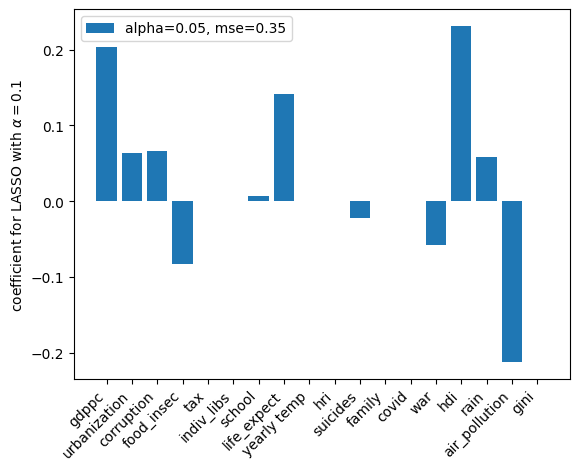

In [8]:
a = 0.05
model = Lasso(alpha=a)
model.fit(X, y)

mse = mean_squared_error(model.predict(X), y)
expl_var = explained_variance_score(model.predict(X), y)

lin_reg_coefs = model.coef_

feature_labels = X_with_labels.columns.values

fig, ax = plt.subplots()
ax.bar(feature_labels, lin_reg_coefs, label=f"alpha={a}, mse={mse:.2f}")
plt.xticks(rotation=45, ha='right')
plt.legend()
ax.set_ylabel(r"coefficient for LASSO with $\alpha = 0.1$")



# PCA + XGBoost Trees

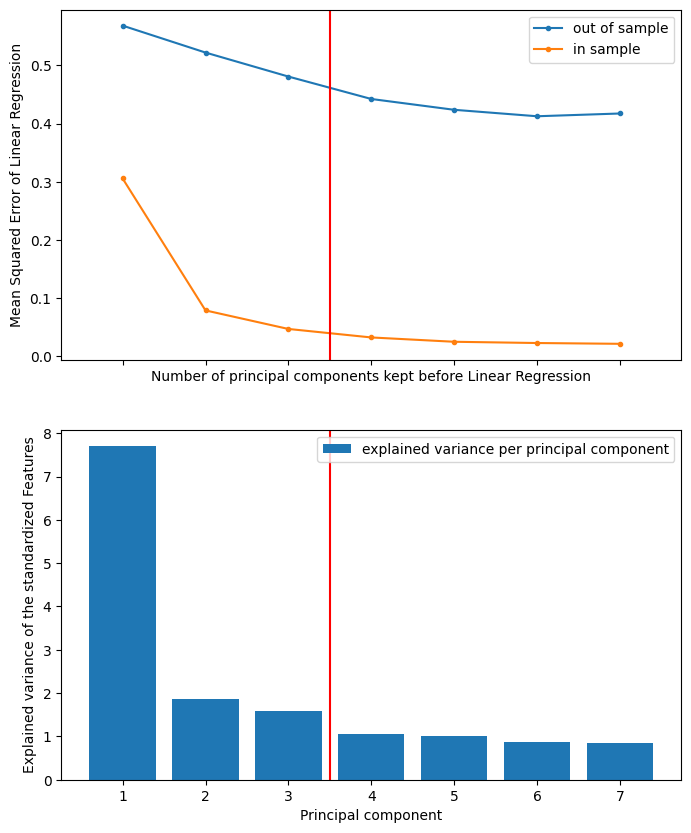

In [55]:
# determining best number of pca components

kf = KFold(n_splits=5, shuffle=True)
n_feat = 7 # len(X_with_labels.columns)
n_comps = range(1,n_feat+1)
principal_variance = np.zeros(len(n_comps))
errors = np.ones((len(n_comps), 2))
lin_reg_coefs = np.zeros(n_feat)

for n in n_comps:
  pca = PCA(n_components=n)
  X_pca = pca.fit_transform(X)
  if n == n_feat:
    principal_variance = pca.explained_variance_

  model = XGBRegressor(objective='reg:squarederror', eta=0.1, n_estimators=100, subsample=0.5)
  mse_in_sample = []
  mse_out_sample = []
  for train_country_index, val_country_index in kf.split(codes):

    # Split the dataset into training and validation sets based on countries
    train_index = df["code"].isin(codes[train_country_index])
    val_index = df["code"].isin(codes[val_country_index])
    X_train, X_val = X_pca[train_index], X_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model.fit(X_train, y_train)

    mse_in_sample.append(mean_squared_error(model.predict(X_train), y_train))
    mse_out_sample.append(mean_squared_error(model.predict(X_val), y_val))
  errors[n-1, 0] = np.mean(mse_in_sample)
  errors[n-1, 1] = np.mean(mse_out_sample)



fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8,10))
ax1.plot(n_comps, errors[:,1], '.-', label='out of sample')
ax1.plot(n_comps, errors[:,0], '.-', label='in sample')
ax2.bar(n_comps, principal_variance, label='explained variance per principal component')
ax1.set_xlabel("Number of principal components kept before Linear Regression")
ax1.set_ylabel("Mean Squared Error of Linear Regression")
ax1.axvline(3.5, c='r')
ax2.axvline(3.5, c='r')
ax2.set_ylabel("Explained variance of the standardized Features")
ax2.set_xlabel("Principal component")
ax2.set_xticks(n_comps)
ax1.legend()
ax2.legend()
